In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
##read datasets
df=pd.read_pickle(r"cust_final_20191030.pkl")

In [3]:
df.columns 

Index(['MOBILE', 'PRODUCT_GROUP', 'MEMBER_ID_nunique', 'ACTIVITY_ID_nunique',
       'ACTIVITY_VALUE_max', 'ACTIVITY_VALUE_min', 'ACTIVITY_VALUE_median',
       'ACTIVITY_VALUE_std', 'ACTIVITY_VALUE_mean', 'ALLOCATED_POINTS_max',
       ...
       'CLIENT_EXI_3M', 'TIME_DECISION_DATE', 'RISK_FPD30', 'RISK_AGRF30',
       'RISK_FSPD30', 'RISK_AGRF60', 'RISK_FSTPD30', 'RISK_AGRF90',
       'RISK_FSTQPD30', 'RISK_AGRF120'],
      dtype='object', length=477)

In [4]:
df.dropna(subset=['HC_SCORE'],inplace=True)
df = df[(df['RISK_AGRF120']== 1) & (df['PRODUCT_GROUP']=='CL')]

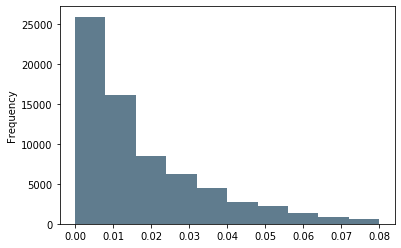

In [5]:
# Check distribution of scores
pd.Series(df['HC_SCORE']).plot.hist(bins=10, range=(0,0.08) ,color='#607c8e')

In [6]:
X=df.drop(['MOBILE','RISK_AGRF30','RISK_FPD30','RISK_FSPD30','RISK_FSTPD30',
           'RISK_FSTQPD30','CLIENT_EXI_3M','PRODUCT_GROUP', 'TIME_DECISION_DATE_max', 'ACTIVITY_DATE_min', 'ACTIVITY_DATE_max', 
            'TIME_DECISION_DATE'] ,axis=1)
Y=df[['RISK_FSTQPD30']]

In [7]:
hcc_score='HC_SCORE'

# HCC score Gini         
y_hcc = X[hcc_score]
df_hcc = pd.DataFrame({'true': np.ravel(Y), 'predict': y_hcc})
df_hcc = df_hcc.loc[pd.notnull(df_hcc['predict']),:]
metric_auc_hcc = metrics.roc_auc_score(df_hcc['true'], df_hcc['predict'])
gini_hcc_only = 2 * metric_auc_hcc - 1
print("HCIN SCORE GINI:" ,gini_hcc_only)

HCIN SCORE GINI: 0.1307856681472077


In [8]:
# split data into train and test sets
seed = 25522
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

# X_train.drop('UW_SC',axis=1,inplace=True) 
# X_test.drop('UW_SC',axis=1,inplace=True) 

##event rate
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(y_train.iloc[:,0]) / len(y_train.iloc[:,0])))
print("\n Train set shape:",X_train.shape)
print("\nEvent rate in test set :", '{:,.2%}'.format(sum(y_test.iloc[:,0]) / len(y_test.iloc[:,0])))
print("\n Test set shape:",X_test.shape)
print("\nEvent rate in validation set :", '{:,.2%}'.format(sum(y_valid.iloc[:,0]) / len(y_valid.iloc[:,0])))
print("\n validation set shape:",X_valid.shape)
print("\n Train GINI",  metrics.roc_auc_score(y_train, X_train['HC_SCORE'])*2 -1)
print("\n Test GINI",  metrics.roc_auc_score(y_test, X_test['HC_SCORE'])*2 -1)
print("\n validation GINI",  metrics.roc_auc_score(y_valid, X_valid['HC_SCORE'])*2 -1)

## fecth original test data
train,test = train_test_split(df, test_size=test_size, random_state=seed)
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(train['RISK_FSTQPD30']) / len(train.iloc[:,0])))
print("\n Train set shape:",train.shape)
print("\n Train GINI",  metrics.roc_auc_score(train['RISK_FSTQPD30'], train['HC_SCORE'])*2 -1)

print("\nEvent rate in test set :", '{:,.2%}'.format(sum(test['RISK_FSTQPD30']) / len(test.iloc[:,0])))
print("\n test set shape:",test.shape)
print("\n test GINI",  metrics.roc_auc_score(test['RISK_FSTQPD30'], test['HC_SCORE'])*2 -1)


Event rate in train set : 2.24%

 Train set shape: (38897, 465)

Event rate in test set : 2.32%

 Test set shape: (20839, 465)

Event rate in validation set : 2.39%

 validation set shape: (9725, 465)

 Train GINI 0.12215788303162922

 Test GINI 0.12959869343938468

 validation GINI 0.1653300798773687

Event rate in train set : 2.27%

 Train set shape: (48622, 477)

 Train GINI 0.13131261309476305

Event rate in test set : 2.32%

 test set shape: (20839, 477)

 test GINI 0.12959869343938468


In [9]:
#X_test_pkl = X_test
#X_test_pkl['RISK_FSTQPD30'] = y_test
#X_test_pkl.to_pickle("cd\\pillar_test_set.pkl")

In [10]:
## Variable importance
def fimportances(xc, predictors):
    importances = pd.DataFrame({'predictor': predictors, 'importance': xc.feature_importances_})
    importances = importances[importances['importance'] > 0]
    importances.sort_values(by='importance', ascending=False, inplace=True)
    importances.reset_index(inplace=True, drop=True)
    importances = importances[['predictor', 'importance']]
    return importances

In [11]:
xgb_model = xgb.XGBClassifier(max_depth = 3,
              learning_rate= 0.01,
              subsample= 0.6,
              min_child_weight= 10,
              colsample_bytree= 0.6,
              scale_pos_weight =25,
              objective= 'binary:logistic', 
              nthread = -1, 
              n_estimators = 200              
              )

evals=[(X_train.drop(columns='HC_SCORE'), np.ravel(y_train)),(X_valid.drop(columns='HC_SCORE'), np.ravel(y_valid))]

bst = xgb_model.fit(X_train.drop(columns='HC_SCORE'), np.ravel(y_train), eval_metric="auc", eval_set=evals,
                    early_stopping_rounds=40   ,  verbose=False)

In [12]:
imp = fimportances(bst,X_train.drop(columns='HC_SCORE').columns)

In [13]:
bst1 = bst
X_train_1 = X_train.drop(columns='HC_SCORE')
X_valid_1 = X_valid.drop(columns='HC_SCORE')
select_X_train = X_train_1

dic_imp = {"n":[imp.shape[0]],"Gini Train":[0],"Gini Test":[0],"Predictors":[list(imp['predictor'])]}

while(select_X_train.shape[1] > 1):
    select_X_train = X_train_1[list(imp['predictor'])[:-2]]
    select_X_valid = X_valid_1[list(imp['predictor'])[:-2]]
    xgb_model = xgb.XGBClassifier(max_depth = 3,
              learning_rate= 0.01,
              subsample= 0.6,
              min_child_weight= 10,
              colsample_bytree= 0.6,
              scale_pos_weight =25,
              objective= 'binary:logistic', 
              nthread = -1, 
              n_estimators = 200              
              )

    evals=[(select_X_train, np.ravel(y_train)),(select_X_valid, np.ravel(y_valid))]

    bst = xgb_model.fit(select_X_train, np.ravel(y_train), eval_metric="auc", eval_set=evals,
                        early_stopping_rounds=40   ,  verbose=False)
    
    ypred_train = bst.predict_proba(select_X_train)[:, 1]
    ypred_test  = bst.predict_proba(select_X_valid)[:, 1]
    
    metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
    metric_auc_test = metrics.roc_auc_score(y_valid, ypred_test)

    gini_train = 2 * metric_auc_train - 1
    gini_test = 2 * metric_auc_test - 1
    
    print("Columns Remaining : %d , gini_train: %f,gini_test: %f "%(select_X_train.shape[1],gini_train,gini_test))
    
    dic_imp['n'].append(imp.shape[0])
    dic_imp['Gini Train'].append(gini_train)
    dic_imp['Gini Test'].append(gini_test)
    dic_imp['Predictors'].append(list(imp['predictor']))
    
    imp = fimportances(bst,select_X_train.columns)

Columns Remaining : 241 , gini_train: 0.311421,gini_test: 0.247818 
Columns Remaining : 129 , gini_train: 0.329709,gini_test: 0.238664 
Columns Remaining : 110 , gini_train: 0.324292,gini_test: 0.278168 
Columns Remaining : 90 , gini_train: 0.321128,gini_test: 0.249263 
Columns Remaining : 84 , gini_train: 0.367992,gini_test: 0.254640 
Columns Remaining : 82 , gini_train: 0.320533,gini_test: 0.265965 
Columns Remaining : 73 , gini_train: 0.325361,gini_test: 0.245041 
Columns Remaining : 70 , gini_train: 0.336224,gini_test: 0.251418 
Columns Remaining : 67 , gini_train: 0.304289,gini_test: 0.252061 
Columns Remaining : 62 , gini_train: 0.318426,gini_test: 0.245987 
Columns Remaining : 56 , gini_train: 0.344407,gini_test: 0.244530 
Columns Remaining : 54 , gini_train: 0.313658,gini_test: 0.243771 
Columns Remaining : 52 , gini_train: 0.324528,gini_test: 0.240786 
Columns Remaining : 49 , gini_train: 0.308355,gini_test: 0.239765 
Columns Remaining : 45 , gini_train: 0.356588,gini_test: 0.

In [14]:
df_imp =pd.DataFrame(dic_imp)

In [15]:
list(df_imp[df_imp['n']==23]["Predictors"])

[['ACTIVITY_VALUE_std',
  'month_nunique_DEBIT_1000_Earn',
  'mesdq_max',
  'month_nunique_GROCERY_1000_Earn',
  'ALLOCATED_POINTS_std',
  'month_nunique_DEBIT_90_by_1000_Earn',
  'ALLOCATED_POINTS_std_GROCERY_1000_Earn',
  'ALLOCATED_POINTS_sum_DEBIT_90_by_1000_Earn',
  'ALLOCATED_POINTS_mean_E_WALLET_365_Earn',
  'ALLOCATED_POINTS_EARN_LAG3',
  'ALLOCATED_POINTS_std_E_WALLET_1000_Earn',
  'ALLOCATED_POINTS_median_E_WALLET_180_Earn',
  'month_nunique_FUEL_1000_Earn',
  'ALLOCATED_POINTS_mean_DEBIT_90_by_1000_Earn',
  'ALLOCATED_POINTS_max_APPAREL_365_Earn',
  'ALLOCATED_POINTS_sum_365_Burn',
  'ALLOCATED_POINTS_mean_E_WALLET_180_Earn',
  'ALLOCATED_POINTS_max_DEBIT_1000_Earn',
  'ALLOCATED_POINTS_mean_E_WALLET_365_by_1000_Earn',
  'ALLOCATED_POINTS_sum_DEBIT_1000_Earn',
  'ACTIVITY_VALUE_median_GROCERY_1000_Earn',
  'ALLOCATED_POINTS_sum_180_Burn',
  'ACTIVITY_VALUE_median_E_WALLET_180_Earn']]

In [16]:
selected_vars = list(df_imp[df_imp['n']==23]["Predictors"])

In [17]:
selected_vars

[['ACTIVITY_VALUE_std',
  'month_nunique_DEBIT_1000_Earn',
  'mesdq_max',
  'month_nunique_GROCERY_1000_Earn',
  'ALLOCATED_POINTS_std',
  'month_nunique_DEBIT_90_by_1000_Earn',
  'ALLOCATED_POINTS_std_GROCERY_1000_Earn',
  'ALLOCATED_POINTS_sum_DEBIT_90_by_1000_Earn',
  'ALLOCATED_POINTS_mean_E_WALLET_365_Earn',
  'ALLOCATED_POINTS_EARN_LAG3',
  'ALLOCATED_POINTS_std_E_WALLET_1000_Earn',
  'ALLOCATED_POINTS_median_E_WALLET_180_Earn',
  'month_nunique_FUEL_1000_Earn',
  'ALLOCATED_POINTS_mean_DEBIT_90_by_1000_Earn',
  'ALLOCATED_POINTS_max_APPAREL_365_Earn',
  'ALLOCATED_POINTS_sum_365_Burn',
  'ALLOCATED_POINTS_mean_E_WALLET_180_Earn',
  'ALLOCATED_POINTS_max_DEBIT_1000_Earn',
  'ALLOCATED_POINTS_mean_E_WALLET_365_by_1000_Earn',
  'ALLOCATED_POINTS_sum_DEBIT_1000_Earn',
  'ACTIVITY_VALUE_median_GROCERY_1000_Earn',
  'ALLOCATED_POINTS_sum_180_Burn',
  'ACTIVITY_VALUE_median_E_WALLET_180_Earn']]

In [18]:
X_train_2=X_train[selected_vars[0]]
X_test_2=X_test[selected_vars[0]]
X_valid_2=X_valid[selected_vars[0]]


print("\n Train shape:",X_train_2.shape,"\n Test shape:",X_test_2.shape,"\n Validation shape:",X_valid_2.shape)


 Train shape: (38897, 23) 
 Test shape: (20839, 23) 
 Validation shape: (9725, 23)


In [19]:
# set model parameters 
missing_value=None; cpu=-1; early_stopping_round=40; split_random_state=None
kfolds = StratifiedKFold(6, random_state=1)

In [20]:
## XGB model##
param_grid = {'max_depth': list(range(1, 6)),
              'learning_rate': np.arange(0.001, 0.02, 0.001),
              'subsample': np.arange(0.4, 0.7,0.05),
              'min_child_weight': np.arange(1, 25, 3),
              'colsample_bytree': np.arange(0.5, 0.75, 0.05),
              'scale_pos_weight' :np.arange(5, 40, 2)
            }

if X_train_2.shape[1] == 1:
    param_grid['colsample_bytree'] = [1]
    
param_dist = {'objective': 'binary:logistic', 'nthread': cpu, 'n_estimators': 200}
xgb_model = xgb.XGBClassifier(**param_dist)

##random search XGB    
clf = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, scoring=['roc_auc'], n_iter=100,
                         random_state=40, cv=kfolds.split(X_train_2, y_train), refit='roc_auc',error_score=0, return_train_score =True)
print("Randomized search..")
search_time_start = time.time()
clf.fit(X_train_2, np.ravel(y_train))
print("Randomized search time:", time.time() - search_time_start)
params = clf.best_params_

dic=clf.cv_results_

params_bst = params
params_tbl = pd.DataFrame(columns=list(params_bst.keys()))  
params_tbl.loc['0'] = [params_bst[k] for k in params_tbl.columns]

print("Best score: {}".format(clf.best_score_))
print("Best params: ")
for param_name in sorted(params_bst.keys()):
    print('%s: %r' % (param_name, params_bst[param_name]))

params.update(param_dist)
xgb_model = xgb.XGBClassifier(**params)

Randomized search..


KeyboardInterrupt: 

In [25]:
pd.Series(dic['mean_train_roc_auc']).to_csv("CL_mean_train_roc_auc.csv")

C:\Users\sgupta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [26]:
pd.Series(dic['mean_test_roc_auc']).to_csv("CL_mean_test_roc_auc_mesdq.csv")

C:\Users\sgupta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [27]:
pd.DataFrame(dic['params']).to_csv("CL_params.csv")

In [26]:
# colsample_bytree: 0.7000000000000002
# learning_rate: 0.016
# max_depth: 5
# min_child_weight: 10
# scale_pos_weight: 5
# subsample: 0.6pd.DataFrame(dic['params']).to_csv("params_mesdq.csv")

In [21]:

#First Run
xgb_model = xgb.XGBClassifier(max_depth =5,
              learning_rate= 0.005,
              subsample= 0.65,
              min_child_weight= 19,
              colsample_bytree= 0.7,
              scale_pos_weight =11,
              objective= 'binary:logistic', 
              nthread = -1, 
              n_estimators = 200
             )
#GINI TRAIN: 

#GINI Validation: 

#GINI CV: 

#Gini Test 

In [22]:
#if required
#%env JOBLIB_TEMP_FOLDER=/tmp

In [23]:
# cross validation gini
def xgboost(X_tr,X_ts,y_tr,y_ts):
    auc_cv = cross_val_score(xgb_model, X_tr, np.ravel(y_tr), scoring='roc_auc', cv=kfolds.split(X_tr, np.ravel(y_tr)),
                             n_jobs=1)
    gini_cv = (2 * np.array(auc_cv) - 1).mean()
    evals=[(X_tr, np.ravel(y_tr)),(X_ts, np.ravel(y_ts))]

    bst = xgb_model.fit(X_tr, np.ravel(y_tr), eval_metric="auc", eval_set=evals,
                        early_stopping_rounds=early_stopping_round   ,  verbose=False)

    if early_stopping_round is None:
        ypred_train = bst.predict_proba(X_tr)[:, 1]
        ypred_test = bst.predict_proba(X_ts)[:, 1]
    else:
        ypred_train = bst.predict_proba(X_tr, ntree_limit=bst.best_ntree_limit)[:, 1]
        ypred_test = bst.predict_proba(X_ts, ntree_limit=bst.best_ntree_limit)[:, 1]

    metric_auc_train = metrics.roc_auc_score(y_tr, ypred_train)
    metric_auc_test = metrics.roc_auc_score(y_ts, ypred_test)

    gini_train = 2 * metric_auc_train - 1
    gini_test = 2 * metric_auc_test - 1

    return bst,gini_cv,gini_train,gini_test,ypred_train,ypred_test

In [24]:
## run xgboost
bst,gini_cv,gini_train,gini_test,ypred_train,ypred_test=xgboost(X_train_2, X_valid_2, y_train, y_valid)

##Model performance on sample
print("GINI TRAIN:",gini_train )
print("\nGINI Validation:",gini_test )
print("\nGINI CV:",gini_cv )

GINI TRAIN: 0.4075588682660356

GINI Validation: 0.23605596864477274

GINI CV: 0.2346284479793909


In [25]:
X_train_2.columns

Index(['ACTIVITY_VALUE_std', 'month_nunique_DEBIT_1000_Earn', 'mesdq_max',
       'month_nunique_GROCERY_1000_Earn', 'ALLOCATED_POINTS_std',
       'month_nunique_DEBIT_90_by_1000_Earn',
       'ALLOCATED_POINTS_std_GROCERY_1000_Earn',
       'ALLOCATED_POINTS_sum_DEBIT_90_by_1000_Earn',
       'ALLOCATED_POINTS_mean_E_WALLET_365_Earn', 'ALLOCATED_POINTS_EARN_LAG3',
       'ALLOCATED_POINTS_std_E_WALLET_1000_Earn',
       'ALLOCATED_POINTS_median_E_WALLET_180_Earn',
       'month_nunique_FUEL_1000_Earn',
       'ALLOCATED_POINTS_mean_DEBIT_90_by_1000_Earn',
       'ALLOCATED_POINTS_max_APPAREL_365_Earn',
       'ALLOCATED_POINTS_sum_365_Burn',
       'ALLOCATED_POINTS_mean_E_WALLET_180_Earn',
       'ALLOCATED_POINTS_max_DEBIT_1000_Earn',
       'ALLOCATED_POINTS_mean_E_WALLET_365_by_1000_Earn',
       'ALLOCATED_POINTS_sum_DEBIT_1000_Earn',
       'ACTIVITY_VALUE_median_GROCERY_1000_Earn',
       'ALLOCATED_POINTS_sum_180_Burn',
       'ACTIVITY_VALUE_median_E_WALLET_180_Earn'],
     

In [26]:
#ypred_test = bst.predict_proba(X_test_2.drop(columns=['act','pred']), ntree_limit=bst.best_ntree_limit)[:, 1]
ypred_test = bst.predict_proba(X_test_2, ntree_limit=bst.best_ntree_limit)[:, 1]
metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)
print("Gini Test",metric_auc_test*2-1)

Gini Test 0.189860756692672


In [27]:
importance_tbl = fimportances(bst, X_train_2.columns)
importance_tbl.to_csv(r"xgb_cl_fstq_varimp.csv",index=0)

In [28]:
importance_tbl = fimportances(bst, X_train_2.columns)
importance_tbl.head(50)

,predictor,importance
0,ACTIVITY_VALUE_std,0.075110
1,month_nunique_DEBIT_1000_Earn,0.069328
2,ALLOCATED_POINTS_sum_180_Burn,0.053914
3,mesdq_max,0.052465
4,month_nunique_GROCERY_1000_Earn,0.049512
5,ALLOCATED_POINTS_sum_DEBIT_90_by_1000_Earn,0.049204
6,month_nunique_DEBIT_90_by_1000_Earn,0.048626
7,ALLOCATED_POINTS_max_DEBIT_1000_Earn,0.043997
8,ALLOCATED_POINTS_mean_E_WALLET_180_Earn,0.043634
9,ALLOCATED_POINTS_sum_365_Burn,0.043092


In [29]:
## save the model 
pickle.dump(bst, open("xgb_cl_fstq_wo_hc.mod", "wb"))
##Score the dataset
outtest=X_test_2;  outtest['pred']=ypred_test ; outtest['act']=y_test ; 
outtest.to_csv(r"xgb_cl_fstq_wohc.csv")

C:\Users\sgupta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


[[19359   996]
 [  438    46]]

 Log Loss is : 0.5383126306278679
Average precision-recall score: 0.03


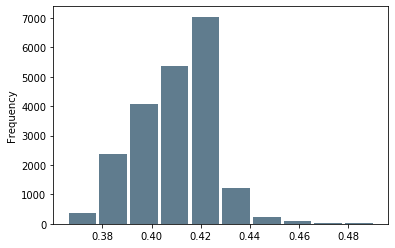

In [30]:
#metrics calculation
cutoff=np.percentile(X_test['HC_SCORE'],95)
ypred=pd.Series(X_test['HC_SCORE']).apply(lambda x : 1 if x >cutoff else 0 )
#ypred=pd.Series(ypred_test).apply(lambda x : 1 if x > 0.48631722 else 0 )

print(confusion_matrix(y_test, ypred))
pd.Series(ypred_test).plot.hist(bins=10, rwidth=0.9 ,color='#607c8e')

print("\n Log Loss is :",log_loss(y_test, ypred_test))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, ypred_test)))

In [31]:
# retrieve performance metrics
results = bst.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

Text(0.5, 1.0, 'XGBoost AUC')

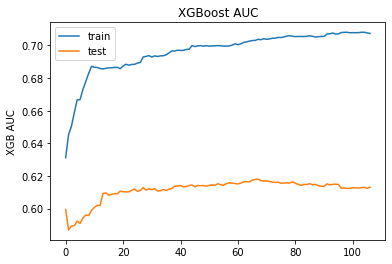

In [32]:
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='train')
ax.plot(x_axis, results['validation_1']['auc'], label='test')

ax.legend()
plt.ylabel('XGB AUC')
plt.title('XGBoost AUC')

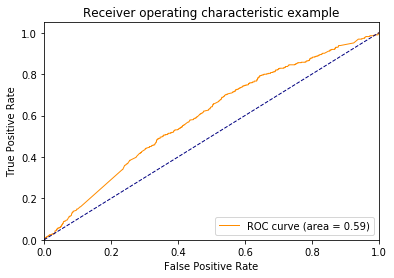

In [33]:
# Compute micro-average ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test.iloc[:, 0].ravel(), ypred_test.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[]

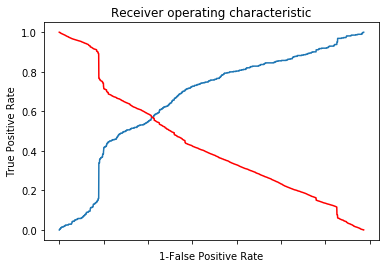

In [34]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.ix[(roc.tf-0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

In [35]:
optimal_idx = np.argmax(tpr - fpr)  ## check it once 
optimal_threshold = thresholds[optimal_idx]
print("\n Optimal Cut off :",optimal_threshold)


 Optimal Cut off : 0.41186607


In [36]:
print(" \n Min -Max test score:",test['HC_SCORE'].min(),"\t",test['HC_SCORE'].max())
print(" \n Min -Max train score:",train['HC_SCORE'].min(),"\t",train['HC_SCORE'].max())

 
 Min -Max test score: 0.00028829080916565323 	 0.3394530317701768
 
 Min -Max train score: 0.0002892256188921669 	 0.4294863632786921


In [37]:
## Bad rates in overall population 
cd=pd.DataFrame(df[['HC_SCORE','RISK_FSTQPD30']]).sort_values(by=['HC_SCORE'],ascending=False)
print("\nTotal bad :",df['RISK_FSTQPD30'].sum())
print("Bad captured in worst category :",'{:,.2%}'.format(cd.groupby(pd.qcut(cd['HC_SCORE'],10,duplicates='drop')).sum()['RISK_FSTQPD30'][-1]/df['RISK_FSTQPD30'].sum()))
print("\n",cd.groupby(pd.qcut(cd['HC_SCORE'],10,duplicates='drop')).mean())
print(cd.groupby(pd.qcut(cd['HC_SCORE'],10,duplicates='drop')).sum())


Total bad : 1587
Bad captured in worst category : 17.96%

                       HC_SCORE  RISK_FSTQPD30
HC_SCORE                                     
(-0.000712, 0.00284]  0.001900       0.009069
(0.00284, 0.00449]    0.003674       0.016268
(0.00449, 0.00634]    0.005394       0.024331
(0.00634, 0.00865]    0.007460       0.026346
(0.00865, 0.0116]     0.010114       0.026490
(0.0116, 0.0158]      0.013661       0.024618
(0.0158, 0.0219]      0.018776       0.017276
(0.0219, 0.0303]      0.026042       0.018572
(0.0303, 0.0434]      0.036294       0.024418
(0.0434, 0.429]       0.059605       0.041126
                        HC_SCORE  RISK_FSTQPD30
HC_SCORE                                       
(-0.000712, 0.00284]   13.198643             63
(0.00284, 0.00449]     25.519453            113
(0.00449, 0.00634]     37.466736            169
(0.00634, 0.00865]     51.819023            183
(0.00865, 0.0116]      70.249262            184
(0.0116, 0.0158]       94.891460            171
(0.0

In [38]:
## Bad rates in overall population 
cd=pd.DataFrame(test[['HC_SCORE','RISK_FSTQPD30']]).sort_values(by=['HC_SCORE'],ascending=False)
print("\nTotal bad :",test['RISK_FSTQPD30'].sum())
print("Bad captured in worst category :",'{:,.2%}'.format(cd.groupby(pd.qcut(cd['HC_SCORE'],10,duplicates='drop')).sum()['RISK_FSTQPD30'][-1]/test['RISK_FSTQPD30'].sum()))
print("\n",cd.groupby(pd.qcut(cd['HC_SCORE'],10,duplicates='drop')).mean())
print(cd.groupby(pd.qcut(cd['HC_SCORE'],10,duplicates='drop')).sum())


Total bad : 484
Bad captured in worst category : 16.74%

                       HC_SCORE  RISK_FSTQPD30
HC_SCORE                                     
(-0.000712, 0.00284]  0.001896       0.008637
(0.00284, 0.00452]    0.003689       0.017754
(0.00452, 0.00634]    0.005411       0.025912
(0.00634, 0.00863]    0.007451       0.024952
(0.00863, 0.0116]     0.010160       0.024928
(0.0116, 0.0158]      0.013665       0.026910
(0.0158, 0.0219]      0.018780       0.017754
(0.0219, 0.0301]      0.025957       0.018714
(0.0301, 0.0431]      0.036159       0.027831
(0.0431, 0.339]       0.058745       0.038868
                        HC_SCORE  RISK_FSTQPD30
HC_SCORE                                       
(-0.000712, 0.00284]    3.950372             18
(0.00284, 0.00452]      7.687996             37
(0.00452, 0.00634]     11.276430             54
(0.00634, 0.00863]     15.528895             52
(0.00863, 0.0116]      21.193236             52
(0.0116, 0.0158]       28.436982             56
(0.01

In [39]:
## Bad rates in overall population 
cdt=pd.DataFrame(outtest[['pred','act']])
print("Bad captured in worst category Partner Score test sample :",'{:,.2%}'.format(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).sum()['act'][-1]/cdt['act'].sum()))
print("\nTotal bads in test sample:",cdt['act'].sum())
print(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).mean())
print(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).sum())

Bad captured in worst category Partner Score test sample : 14.88%

Total bads in test sample: 484
                      pred       act
pred                                
(0.3655, 0.3884]  0.384408  0.012600
(0.3884, 0.3953]  0.392429  0.016228
(0.3953, 0.4013]  0.398438  0.013436
(0.4013, 0.4087]  0.404763  0.017754
(0.4087, 0.4134]  0.411534  0.024460
(0.4134, 0.4166]  0.414629  0.024976
(0.4166, 0.4256]  0.421928  0.023224
(0.4256, 0.4267]  0.426533  0.033498
(0.4267, 0.4269]  0.426880  0.023148
(0.4269, 0.4907]  0.434683  0.034732
                         pred  act
pred                              
(0.3655, 0.3884]   915.275085   30
(0.3884, 0.3953]   701.270264   29
(0.3953, 0.4013]   830.345520   28
(0.4013, 0.4087]   843.526550   37
(0.4087, 0.4134]   858.048157   51
(0.4134, 0.4166]   863.257751   52
(0.4166, 0.4256]   926.553284   51
(0.4256, 0.4267]  1642.577637  129
(0.4267, 0.4269]    92.206161    5
(0.4269, 0.4907]   901.098145   72


In [40]:
## Pillar  approach to combine score
hcc_score = 'HC_SCORE'
X_pillar_train = pd.DataFrame()
X_pillar_test = pd.DataFrame()

X_pillar_train[hcc_score]=train['HC_SCORE']; 
X_pillar_test[hcc_score]=test['HC_SCORE']

X_pillar_train["XGB_SCORE"] =  bst.predict_proba(train[selected_vars[0]], ntree_limit=bst.best_ntree_limit)[:, 1]
X_pillar_test["XGB_SCORE"]  =  bst.predict_proba(test[selected_vars[0]], ntree_limit=bst.best_ntree_limit)[:, 1]

X_pillar_train["FSTQ"] = train['RISK_FSTQPD30']
X_pillar_test["FSTQ"] = test['RISK_FSTQPD30']

X_train_log = X_pillar_train.loc[pd.notnull(X_pillar_train[hcc_score]),['HC_SCORE','XGB_SCORE']]
y_train_log = X_pillar_train.loc[pd.notnull(X_pillar_train[hcc_score]),['FSTQ']]

X_test_log = X_pillar_test.loc[pd.notnull(X_pillar_test[hcc_score]),['HC_SCORE','XGB_SCORE']]
y_test_log = X_pillar_test.loc[pd.notnull(X_pillar_test[hcc_score]),['FSTQ']]

X_train_log = np.log((X_train_log + 1e-10).divide(1 - (X_train_log + 1e-10)))
X_test_log = np.log((X_test_log + 1e-10).divide(1 - (X_test_log + 1e-10)))

In [41]:
logreg = LogisticRegression(C=11, n_jobs=cpu)

# cross validation gini
kfolds = StratifiedKFold(10, random_state=1)
auc_cv = cross_val_score(logreg, X_test_log, np.ravel(y_test_log), scoring='roc_auc',
                         cv=kfolds.split(X_test_log, np.ravel(y_test_log)), n_jobs=cpu)
gini_cv = (2 * np.array(auc_cv) - 1).mean()

logreg.fit(X_test_log, np.ravel(y_test_log))
log_coef_tbl = pd.DataFrame({'predictor': ['intercept'] + X_test_log.columns.tolist(),
                             'coefficient': list(logreg.intercept_) + list(logreg.coef_[0])})
log_coef_tbl = log_coef_tbl[['predictor', 'coefficient']]

C:\Users\sgupta\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sgupta\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [42]:
log_coef_tbl

,predictor,coefficient
0,intercept,-1.098783
1,HC_SCORE,0.239602
2,XGB_SCORE,4.591305


In [43]:
## Model performance
ypred_train_pillar = logreg.predict_proba(X_train_log)[:, 1]
metric_auc_train_log = metrics.roc_auc_score(np.ravel(y_train_log), ypred_train_pillar)
gini_train_pillar = 2 * metric_auc_train_log - 1
ypred_test_pillar = logreg.predict_proba(X_test_log)[:, 1]
metric_auc_test_log = metrics.roc_auc_score(np.ravel(y_test_log), ypred_test_pillar)
gini_test_pillar = 2 * metric_auc_test_log - 1

print("GINI TRAIN:",gini_test_pillar )
print("\nGINI TEST:",gini_train_pillar )
print("\nGINI CV:",gini_cv )

GINI TRAIN: 0.22972902468782408

GINI TEST: 0.3690938760250062

GINI CV: 0.2289697416041087


In [44]:
outtest1=X_test;  outtest1['pred']=ypred_test_pillar ; outtest1['act']=y_test ; 
outtest1.to_csv(r"comb_cl_fstq.csv")

C:\Users\sgupta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


[[18568  1787]
 [  396    88]]

 Log Loss is : 0.5383126306278679
Average precision-recall score: 0.03


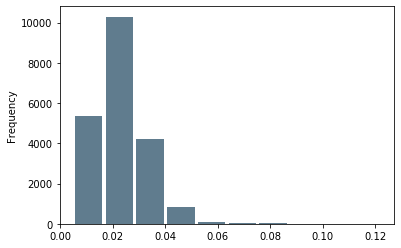

In [45]:
#metrics calculation
cutoff=np.percentile(ypred_test_pillar,91)
ypred=pd.Series(ypred_test_pillar).apply(lambda x : 1 if x >cutoff else 0 )

print(confusion_matrix(y_test, ypred))
pd.Series(ypred_test_pillar).plot.hist(bins=10, rwidth=0.9 ,color='#607c8e')

print("\n Log Loss is :",log_loss(y_test, ypred_test))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, ypred_test)))


 AUC for precision-recall : 0.03794681494346688


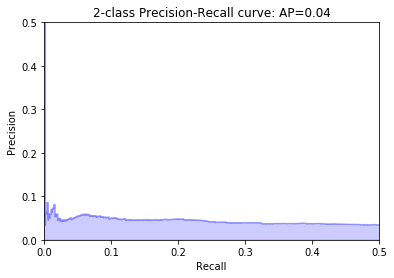

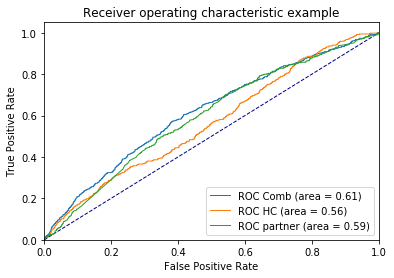

In [46]:
## PRC curve
precision, recall, _ = precision_recall_curve(y_test, ypred_test_pillar)

step_kwargs = ({'step': 'post'}
               #if 'step' in signature(plt.fill_between).parameters
               #else {}
              )
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 0.5])
plt.xlim([0.0, 0.5])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision_score(test['RISK_FSTQPD30'], ypred_test_pillar)))

# calculate precision-recall AUC
auc_pr = auc(recall, precision)
print("\n AUC for precision-recall :",auc_pr)

# Compute micro-average ROC curve and ROC area
fprhc, tprhc, thresholds = roc_curve(test['RISK_FSTQPD30'], test['HC_SCORE'].ravel())
roc_auchc = auc(fprhc, tprhc)

fprc, tprc, thresholds = roc_curve(test['RISK_FSTQPD30'], ypred_test_pillar.ravel())
roc_aucc = auc(fprc, tprc)

plt.figure()
lw = 1
plt.plot(fprc, tprc, lw=lw, label='ROC Comb (area = %0.2f)' % roc_aucc)
plt.plot(fprhc, tprhc, lw=lw, label='ROC HC (area = %0.2f)' % roc_auchc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(fpr, tpr, lw=lw, label='ROC partner (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [47]:
## Bad rates combined score in overall population 
cdt=pd.DataFrame(outtest1[['pred','act']])
print("Bad captured in worst category Partner Score test sample :",'{:,.2%}'.format(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).sum()['act'][-1]/cdt['act'].sum()))
print("\nTotal bads in test sample:",cdt['act'].sum())
print(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).mean())
print(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).sum())

Bad captured in worst category Partner Score test sample : 20.25%

Total bads in test sample: 484
                       pred       act
pred                                 
(0.00397, 0.0129]  0.010956  0.014395
(0.0129, 0.0155]   0.014233  0.012476
(0.0155, 0.0176]   0.016536  0.013916
(0.0176, 0.0196]   0.018605  0.019674
(0.0196, 0.0218]   0.020710  0.017754
(0.0218, 0.0242]   0.022947  0.019683
(0.0242, 0.0268]   0.025459  0.028311
(0.0268, 0.0302]   0.028391  0.030710
(0.0302, 0.0354]   0.032535  0.028311
(0.0354, 0.122]    0.041932  0.047025
                        pred  act
pred                             
(0.00397, 0.0129]  22.833103   30
(0.0129, 0.0155]   29.661794   26
(0.0155, 0.0176]   34.461946   29
(0.0176, 0.0196]   38.773637   41
(0.0196, 0.0218]   43.159379   37
(0.0218, 0.0242]   47.798570   41
(0.0242, 0.0268]   53.056270   59
(0.0268, 0.0302]   59.165896   64
(0.0302, 0.0354]   67.803088   59
(0.0354, 0.122]    87.386702   98
